# Word Vectors ##

*This lesson is based on the [Advanced Topics in Word Vectors workshop](https://dh2018.adho.org/en/machine-reading-part-ii-advanced-topics-in-word-vectors/) at DH 2018 as well as tutorials by [Radim Rehurek](https://rare-technologies.com/word2vec-tutorial/) and [Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)** 

TK: EXPLAIN WHY WORD VECTORS?

## Install gensim

In [2]:
# gensim is already installed on JupyterHub
#!pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 20.2MB/s eta 0:00:01
     |████████████████████████████████| 112kB 4.0MB/s eta 0:00:01
     |████████████████████████████████| 133kB 37.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 3.7MB/s eta 0:00:01
     |████████████████████████████████| 6.6MB 26.4MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.1.1-cp37-none-any.whl size=112415 sha256=c2e84f99dc741f807d39994380e4393f20eb521c2bf29e450edee354baee93a3
  Stored in directory: /Users/dsinyki/Library/Caches/pip/wheels/17/49/ea/74939572d8d071ff3c63a98e3e8dadef1117cc93c33efaa504
Successfully built smart-open


## Import gensim and nltk tokenizers

In [9]:
import gensim # remember this! 
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer
import nltk
nltk.download('punkt')
import glob
from pathlib import Path

[nltk_data] Downloading package punkt to /Users/dsinyki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read in our corpus

In [4]:
# next, we need to create our corpus.
# in this case, we can start by creating the same list of docs as in our previous class

import os

base_dir = "../docs/NYT-Obituaries/" # NOTE: Your path may be different!!!

all_docs = [] # our list which will store the text of each doc; empty for now

docs = os.listdir(base_dir) # get a list of all the files in the directory

for doc in docs: # iterate through the docs
    if not doc.startswith('.'): # get only the .txt files
        with open(base_dir + doc, "r", encoding="utf-8") as file: # force unicode conversion to keep PCs happy
            text = file.read() # read in the file as a single text string
            all_docs.append(text) # append it to the all_docs list

# lastly, just check the length of all_docs to see if it's 147
len(all_docs)

378

## Preprocessing

We need each doc tokenized by sentence. 

So let's define a function that a takes a list of texts (e.g. our all_docs list) and converts it for gensim word2vec to use. The function will lower-case text and tokenize by sentence and word.

In [13]:
# need our handy nltk tokenizer 
tokenizer = TreebankWordTokenizer()

# and we'll get titles
directory = "../docs/NYT-Obituaries/"
files = glob.glob(f"{directory}/*.txt")
obit_titles = [Path(file).stem for file in files]

# and the function
def make_sentences(list_txt):
    all_txt = []
    counter = 0
    for txt in list_txt:
        lower_txt = txt.lower()
        sentences = sent_tokenize(lower_txt)
        sentences = [tokenizer.tokenize(sent) for sent in sentences]
        all_txt += sentences
        print(obit_titles[counter])
        print(len(sentences))  # let's check how many sentences there are per item
        print("\n")
        counter += 1
    return all_txt

In [14]:
# now let's run it

sentences = make_sentences(all_docs)

1945-Adolf-Hitler
597


1915-F-W-Taylor
15


1975-Chiang-Kai-shek
240


1984-Ethel-Merman
110


1953-Jim-Thorpe
79


1964-Nella-Larsen
44


1955-Margaret-Abbott
52


1984-Lillian-Hellman
159


1959-Cecil-De-Mille
65


1928-Mabel-Craty
14


1973-Eddie-Rickenbacker
125


1989-Ferdinand-Marcos
53


1991-Martha-Graham
118


1997-Deng-Xiaoping
274


1938-George-E-Hale
31


1885-Ulysses-Grant
1619


1909-Sarah-Orne-Jewett
20


1957-Christian-Dior
43


1987-Clare-Boothe-Luce
94


1976-Jacques-Monod
41


1954-Getulio-Vargas
56


1979-Stan-Kenton
58


1990-Leonard-Bernstein
203


1972-Jackie-Robinson
164


1998-Fred-W-Friendly
81


1991-Leo-Durocher
44


1915-B-T-Washington
54


1997-James-Stewart
101


1981-Joe-Louis
156


1983-Muddy-Waters
38


1942-George-M-Cohan
160


1989-Samuel-Beckett
160


1962-Marilyn-Monroe
84


2000-Charles-M-Schulz
296


1967-Gregory-Pincus
59


1894-R-L-Stevenson
106


1978-Bruce-Catton
8


1982-Arthur-Rubinstein
174


1875-Andrew-Johnson
103


1974-Charles-Lindber

1981-Robert-Moses
186


1989-Robert-Penn-Warren
84


1901-William-McKinley
161


1970-Walter-Reuther
23


1930-Balfour
141


1984-Indira-Gandhi
309


1978-Golda-Meir
242


1983-Earl-Hines
25


1974-Katharine-Cornell
102


1982-Lee-Strasberg
86


1939-Pope-Pius-XI
112


1886-Mary-Ewing-Outerbridge
49


1993-Dizzy-Gillespie
95


1910-Florence-Nightingale
75


1960-Richard-Wright
36


1986-The-Challenger
38


1992-Menachem-Begin
150


1998-Galina-Ulanova
32


1976-Max-Ernst
98


1993-Cesar-Chavez
78


1965-Adlai-Ewing-Stevenson
187


1935-Adolph-S-Ochs
446


1941-Lou-Gehrig
8


1961-Carl-G-Jung
92


1963-Robert-Frost
108


1965-Edward-R-Murrow
197


1971-Dean-Acheson
166


1986-Jorge-Luis-Borges
102


1966-Walt-Disney
142


1996-Carl-Sagan
58


1959-Ross-G-Harrison
14


1945-Jerome-Kern
62


1991-Frank-Capra
69


1987-Andres-Segovie
85


1987-Rita-Hayworth
62


1993-William-Golding
42


1932-Florenz-Ziegfeld
66


1938-Constantin-Stanislavsky
55




## Train model

To train our vectors we call the function below. This function has a couple dozen parameters, some of which are more important than others.
Here are a few major ones. The fields that are MANDATORY are marked with an asterisk:
1. `sentences*`: This is where you provide your data. It must be in a format of iterable of iterables.
2. `sg`: Your choice of training algorithm. There are two standard ways of training W2V vectors -- 'skipgram' and 'CBOW'. If you enter 1 here the skip-gram is applied; otherwise, the default is CBOW.
3. `size*`: This is the length of your resulting word vectors. If you have a large corpus (>few billion tokens) you can go up to 100-300 dimensions. Generally word vectors with more dimensions give better results.
4. `window`: This is the window of context words you are training on. In other words, how many words come before and after your given word. A good number is 4 here but this can vary depending on what you are interested in. For instance, if you are more interested in embeddings that embody semantic meaning, smaller window sizes work better. 
5. `alpha`: The learning rate of your model. If you are interested in machine learning experimentation with your vectors you may experiment with this parameter.
6. `seed` (int): This is the random seed for your random initialization. All deep learning models initialize the weights with random floats before training. This is a useful field if you want to replicate your experiments because giving this a seed will initialize 'randomly' deterministically.
7. `min_count`: This is the minimum frequency threshold. If a given word appears with lower frequency than provided it will be ignored. This is here because words with very low frequency are hard to train.
8. `iter`: This is the number of iterations(entire run) over the corpus, also known as epochs. Usually anything between 1-10 is ok. The trade offs are that if you have higher iterations, it will take longer to train and the model may overfit on your dataset. However, longer training will allow your vectors to perform better on tasks relevant to your dataset.

Overall, most of these settings will not concern you unless you are interested in very specific usages of word vectors.

In [15]:
# let's train our model!

obit_model = gensim.models.Word2Vec(
    sentences,
    min_count=2, # default is 5; this trims the corpus for words only used once; 
    size=200, # size of NN layers; default is 100; higher for larger corpora
    workers=5) # parallel processing; needs Cython

In [16]:
# take a quick look at the vocab

obit_model.wv.vocab

{'may': <gensim.models.keyedvectors.Vocab at 0x7faff707c5d0>,
 '2': <gensim.models.keyedvectors.Vocab at 0x7faff712fe50>,
 ',': <gensim.models.keyedvectors.Vocab at 0x7fb0112b2c10>,
 '1945': <gensim.models.keyedvectors.Vocab at 0x7fb0112b2c90>,
 'obituary': <gensim.models.keyedvectors.Vocab at 0x7fb0112b2a10>,
 'hitler': <gensim.models.keyedvectors.Vocab at 0x7fb0112a84d0>,
 'fought': <gensim.models.keyedvectors.Vocab at 0x7fb0112a8810>,
 'way': <gensim.models.keyedvectors.Vocab at 0x7fb0112a83d0>,
 'to': <gensim.models.keyedvectors.Vocab at 0x7fb0112b2b90>,
 'power': <gensim.models.keyedvectors.Vocab at 0x7fb0112a8150>,
 'unique': <gensim.models.keyedvectors.Vocab at 0x7fb0112a8050>,
 'in': <gensim.models.keyedvectors.Vocab at 0x7fb0112a8490>,
 'modern': <gensim.models.keyedvectors.Vocab at 0x7fb0112a8210>,
 'history': <gensim.models.keyedvectors.Vocab at 0x7fb0112a80d0>,
 'by': <gensim.models.keyedvectors.Vocab at 0x7fb0112a8110>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7fb011

It's often useful to save your trained model to disk so that you can reload it as needed. 

In [19]:
obit_model.save('obit_model')

And you can load a model in the same way (remember this from our topic model)

In [20]:
old_model = gensim.models.Word2Vec.load('obit_model') 

In [22]:
# testing some basic functions

# basic similarity
obit_model.wv.most_similar("hitler", topn=10)

[('stalin', 0.9219813346862793),
 ('mao', 0.8971244096755981),
 ('israel', 0.8967335820198059),
 ('ireland', 0.8903787136077881),
 ('demonstrating', 0.8855543732643127),
 ('discharge', 0.879696249961853),
 ('bout', 0.878899335861206),
 ('vacation', 0.8766546845436096),
 ('rupture', 0.8756314516067505),
 ('executions', 0.8755513429641724)]

In [28]:
# similarity b/t two words

print(obit_model.wv.similarity(w1="hitler",w2="marilyn"))
print(obit_model.wv.similarity(w1="hitler",w2="truman"))

0.58888423
0.66958153


You can also play with analogy tasks. The commonly seen task is:

'Man is to King as Woman is to ____?'


' A      is to A\*.     as B      is to  B\*  '
                         
Gensim provides two different ways of implementing this task. You may be more familiar with the the additive version also called the 3CosAdd method:

$$\underset{b*\in V}{\textrm{arg max}} (cos(b*,b) - cos(b*,a) + cos(b*,a*))$$

This reflects the abstraction of Woman - Man + King. In this maximization, we are searching which word vector will allow us to produce the highest value in this equation.

We can implement this method with a provided function. Positive here refers to words that give the positive contribution to similarity (nominator), and negative refers to words that contribute negatively (denominatory). Here's the additive method.

In [29]:
# analogies (performed via )
# format is: "freedom is to slavery as liberty is to ???"

obit_model.wv.most_similar(positive=['liberty', 'slavery'], negative=['freedom'])

[('honey', 0.9637875556945801),
 ('1848', 0.9630893468856812),
 ('n.j.', 0.959141731262207),
 ('warner', 0.9567890167236328),
 ('marseilles', 0.9556188583374023),
 ('pitching', 0.9539678692817688),
 ('md.', 0.9528836011886597),
 ('fever', 0.9526484608650208),
 ('honolulu', 0.951981782913208),
 ('slovak', 0.9515334367752075)]

Gensim has quite a few built-in tools, and it's worth taking some time to see what's available. Check the documentation here: [https://radimrehurek.com/gensim/models/keyedvectors.html](https://radimrehurek.com/gensim/models/keyedvectors.html)


In [30]:
### Let's do some visualization ###

import numpy as np

# Get the interactive Tools for Matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

In [31]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


<IPython.core.display.Javascript object>


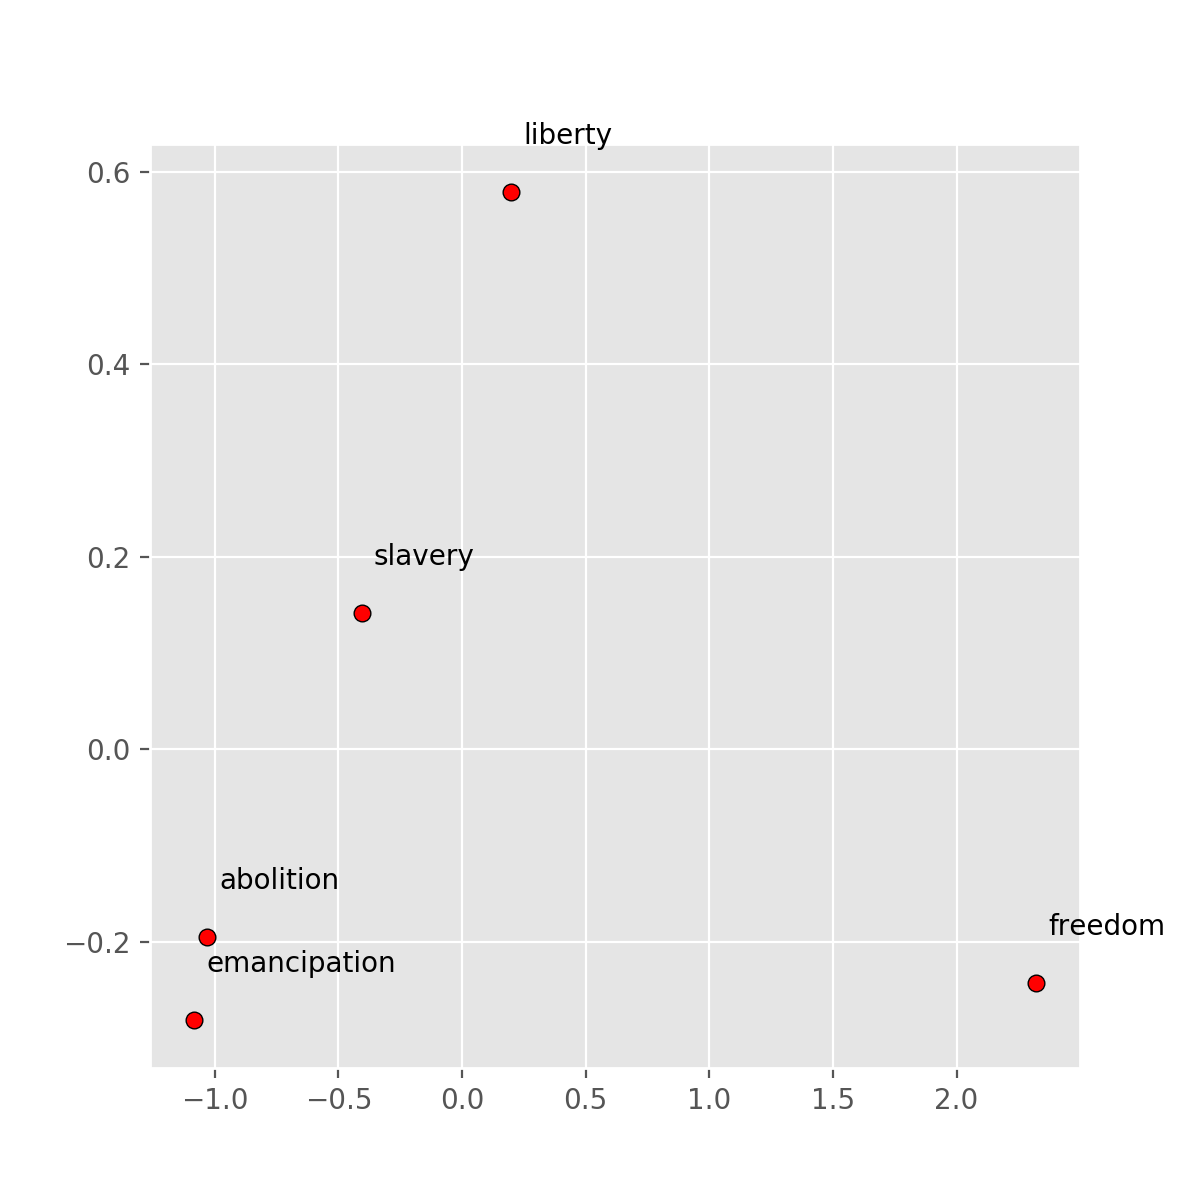

In [33]:
display_pca_scatterplot(obit_model, ['freedom','liberty','slavery','abolition','emancipation'])

# display_pca_scatterplot(ccp_model, sample=20)